In [1]:
from typing import List, TypedDict

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_community.document_loaders import PyPDFLoader, WebBaseLoader
from langchain_community.tools import DuckDuckGoSearchRun, TavilySearchResults
from langchain_community.vectorstores import Chroma
from langchain_core.messages import SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import (ChatGoogleGenerativeAI,
                                    GoogleGenerativeAIEmbeddings)
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()
gemini = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
tavily_tool = TavilySearchResults()
duck_tool = DuckDuckGoSearchRun()

In [4]:
url = "https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148"
loader = WebBaseLoader(url)
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap = 10)
doc_chunks = splitter.split_documents(documents=docs)

db = Chroma.from_documents(documents=doc_chunks, embedding=embedding, collection_name="rag-data")
retriever = db.as_retriever()

In [46]:
class AgentState(TypedDict):
    question: str
    answer: str
    web_search: bool
    documents: List[str]
    

class DocumentRelevance(BaseModel):
    """Provide a score (True or False) regarding query relevance with respect to vector database documnets"""
    is_relevant: bool = Field(..., description="True is query is relevant to the documents chunks stored in vector DB else False")

In [60]:
def relevance_checker(state: AgentState):
    question = state["question"]
    documents = state["documents"]
    llm_relevance_checker = gemini.with_structured_output(DocumentRelevance)
    do_web_search = False
    prompt_template = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                """
                    You are ans expert in finding relevance of a question w.r.t documnets retrieved from vector database.
                    If the documents contain keyword or semantic meaning which can be correlated to the given user question, mark it as
                    relevant and provide a binary answer of True or False. True when relevant, False otherwise.
                """
            ),
            (
                "human",
                "Here is the question: {question}\n and here is the retrieved documnets {documents}",
            ),
        ]
    )

    relevance_chain = prompt_template | llm_relevance_checker
    relevant_docs = []
    for i, doc in enumerate(documents):
        response: DocumentRelevance = relevance_chain.invoke(
            {"question": question, "documents": doc.page_content}
        )
        if response.is_relevant:
            print(f"\n=====Doc {i} Relevant=====")
            relevant_docs.append(doc)
        else:
            print(f"\n=====Doc {i} is not Relevant=====")
            do_web_search = True
    return {
        "question": question,
        "documents": relevant_docs,
        "web_search": do_web_search,
    }

In [50]:
def restructure_question(state: AgentState):
    question = state["question"]
    prompt_template = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                """ 
                    You are an expert in re-formulating an user question, making it grammatically correct irrespective of any previous
                    context so that the restructured question can be used to search web to find a specific answer.
                    Just return the reformulated question. No prefix, suffix or unnecessary alphanumeric characters are NOT required.
                """
            ),
            ("human", "Here is the question: {question}"),
        ]
    )

    rewrite_question_chain = prompt_template | gemini | StrOutputParser()
    response = rewrite_question_chain.invoke({"question": question})
    return {"question": response}

In [51]:
def generate_answer(state: AgentState):
    question = state["question"]
    documents = state["documents"]
    prompt = hub.pull("rlm/rag-prompt")

    rag_chain = (
        {"question": RunnablePassthrough(), "context": documents} | prompt | gemini | StrOutputParser()
    )
    response = rag_chain.invoke(question)
    return {"question": question, "documents": documents, "answer": response}

In [61]:
def search_from_web(state: AgentState):
    print(f"\n=====Initiating web search=====")
    question = state["question"]
    search = DuckDuckGoSearchRun()
    response = search.invoke(question)
    return {"answer": response}

In [53]:
def web_search_or_vector_db(state: AgentState):
    do_web_search = state["web_search"]
    if do_web_search:
        return "web"
    return "vector"

In [28]:
search = DuckDuckGoSearchRun()
ms = search.invoke("What is 8085 chip?")
print(ms)
print(type(ms))

/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


The 8085 microprocessor is an 8-bit microprocessor that was developed by Intel in the mid-1970s. It was widely used in the early days of personal computing and was a popular choice for hobbyists and enthusiasts due to its simplicity and ease of use. ... The 8086 chip, presented by Intel in 1978, is a critical part in the development of ... The 8085 microprocessor is an 8-bit microprocessor. It consists of a 40-pin I.C. package and is fabricated on a single LSI chip. The Intel 8085 only uses a single +5v dc supply for its operation. The clock speed of the microprocessor is about 3MHz and the clock cycle is 320 ns. The time for the clock cycle of Intel 8085AH-2, the version is 200 ns. Developed by Intel and released in March 1976, the 8085 is an 8-bit microprocessor similar to the 8080, with two additional instructions added for its serial I/O and interrupt features.It utilized less circuitry, which allowed lower-cost computers to be built using the 8085 microprocessor. The 8085 featured

In [54]:
def retrieve_doc(state: AgentState):
    print(state)
    question = state["question"]
    relevant_docs = retriever.get_relevant_documents(question)
    return {"documents": relevant_docs, "question": question}

In [62]:
wf = StateGraph(AgentState)

wf.add_node("retrieve_doc", retrieve_doc)
wf.add_node("doc_relevance_check", relevance_checker)
wf.add_node("restructure_question", restructure_question)
wf.add_node("generate_answer", generate_answer)
wf.add_node("search_from_web", search_from_web)

wf.set_entry_point("retrieve_doc")
wf.add_edge("retrieve_doc", "doc_relevance_check")
wf.add_conditional_edges("doc_relevance_check", web_search_or_vector_db, {"web": "restructure_question", "vector": "generate_answer"})
wf.add_edge("restructure_question", "search_from_web")
wf.set_finish_point("generate_answer")
wf.set_finish_point("search_from_web")

app = wf.compile()

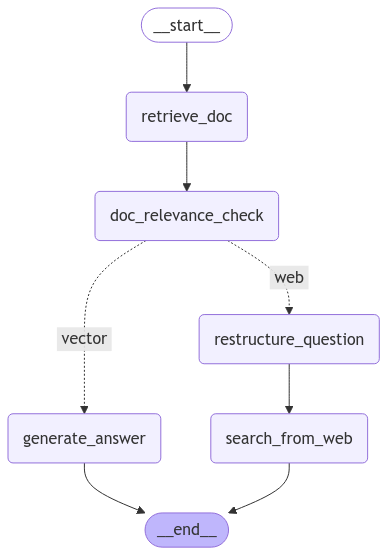

In [63]:
display(Image(app.get_graph().draw_mermaid_png()))

In [64]:
answer = app.invoke({"question": "What is Transformer architecture in deep learning?"})['answer']
print(f"Answer to your question is: \n {answer}")

{'question': 'What is Transformer architecture in deep learning?'}

=====Doc 0 is not Relevant=====

=====Doc 1 is not Relevant=====

=====Doc 2 is not Relevant=====

=====Doc 3 is not Relevant=====

=====Initiating web search=====


/home/bishwayansaha99/langchain/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


Answer to your question is: 
 Transformers are a type of deep learning model that utilizes self-attention mechanisms to process and generate sequences of data efficiently, capturing long-range dependencies and contextual relationships. The article aims to discuss the architecture and working of the transformers model in deep learning. The deep learning field has been experiencing a seismic shift, thanks to the emergence and rapid evolution of Transformer models. ... The main core characteristic of the Transformers architecture is that they maintain the encoder-decoder model. If we start considering a Transformer for language translation as a simple black box, it would take a ... Transformers architecture is a deep learning model introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017. It has revolutionized the field of natural language processing (NLP) and has since been used in various other machine learning tasks due to its remarkable ability to capture long-ran